# SuperEEG demo: infer activity throughout the brain from a small(ish) number of electrodes using Gaussian process regression
Authors: Jeremy R. Manning and Lucy L. W. Owen

Date: July 29, 2018

## Background
How can we know what's happening inside of our brains?  [Electrocorticography (ECoG)](https://en.wikipedia.org/wiki/Electrocorticography) entails taking recordings from electrodes placed directly on the surface of the brain (in humans, this may only be performed in neurosurgical patients, often undergoing treatment for drug-resistent epilepsy).  Like non-invasive methods such as [fMRI](https://en.wikipedia.org/wiki/Functional_magnetic_resonance_imaging), [Scalp EEG](https://en.wikipedia.org/wiki/Electroencephalography), and [MEG](https://en.wikipedia.org/wiki/Magnetoencephalography), ECoG provides a means of gaining insights into ongoing neural activity.  Because ECoG records directly from the brain, it offers an opportunity to gain especially high quality recordings (i.e. recordings at high spatiotemporal resolutions that track reliably with neuronal firing rates and population activity).  However, ECoG suffers from a *coverage problem* in that:
- only a limited number of electrodes may be implanted in any one patient's brain (electrophysiological animal recordings also suffer from this limitation)
- due to clinical considerations, the electrode locations typically vary considerably across patients (animal recordings do *not* typically suffer from this limitation)

[We](https://www.context-lab.com) developed the SuperEEG method to answer the following question: **given recordings from a small(ish) number of electrodes in one patient's brain, how much can we infer about what the rest of their brain was doing at the time the recordings were taken?** The fundamental trick  is to turn the across-patient variability in electrode locations into a strength, rather than a limitation.  Specifically, we try to build a model of how activity in each piece of brain is related to activity in each other piece of brain.  Although we cannot know this model at all brain locations from any one patient, we can build a full brain model by:
- combining data across patients
- building in a *spatial prior*-- this means that, all else being equal (and in the absense of additional information), we assume that nearby brain regions (a) exhibit similar activity patterns and (b) correlate similarly with the rest of the brain

Once we've built this model, we can ask: given that we have a recording taken from a particular set of brain regions (from one patient's brain), and given that we know how every piece of brain relates to every other piece of brain (by stitching together information across patients and applying our spatial prior), what was the rest of that patient's brain most probably doing at the time the recording was taken?

### How does SuperEEG relate to Gaussian process regression?
The "secret sauce" underlying SuperEEG is Gaussian process regression.  Gaussian processes are sometimes described as "infinite dimensional" Gaussians.  A traditional [multivariate Gaussian distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) is parameterized by a mean vector ($\mu$) and a covariance matrix ($\Sigma$): $\mathcal{N}\left(\mu, \Sigma\right)$.  A Gaussian process is parameterized by an analogous set of mathematical objects-- a mean "function" and a covariance "function."  Whereas a vector or matrix explicitly defines values at every possibly location from the start, these mean and covariance functions may be evaluated at arbitrary locations (in geometric space, time, abstract feature space, etc.)  Once these functions are known (or estimated), we can use [Gaussian process regression](https://en.wikipedia.org/wiki/Kriging) to evaluate the most probable behavior (values) of the system at *arbitrary* locations-- even ones we hadn't observed in the original dataset!

In SuperEEG we assume that the mean values at any electrode is 0, thereby eliminating the need for an explicit (non-trivial) mean function.  We estimate the covariance function (equivalent to a correlation function, since we [z-transform](https://en.wikipedia.org/wiki/Standard_score) all recordings along their time dimension as a preprocessing step) by combining data across patients and blurring (smoothing) then over space.  Finally, given (a) recordings from an arbitrary set of locations ($L_{obs}$), (b) the (trivial) mean function (which is 0 everywhere) and (c) the learned covariance function (which we learn from training data), Gaussian process regression allows us to solve out what the (new) patient's brain was most probably doing at any *new* set of locations ($L^*$).

### How does Gaussian process regression relate to the (different) problem *I'm* working on?
If you are (a) trying to build estimates at spaces, times, or feature dimensions that you can't directly observe and (b) you believe the representational space you're trying to predict over is smooth (or approximately smooth), then Gaussian process regression may help!  Although the `supereeg` toolbox is specifically set up to apply these techniques to brain data, the code and/or math could be adapted to operate in many domains using a similar approach.

### Where should I go next?
- [Owen and Manning (2017)](http://biorxiv.org/content/early/2017/03/27/121020.full.pdf).  This paper describes the method and equations in detail, and showcases our attempt to evaluate the approach using a large ECoG dataset
- [This talk](https://www.youtube.com/watch?v=t6snLszEneA&feature=youtu.be&t=35) provides higher-level details than the paper (but more detail than we provide in this tutorial)
- [Here](http://keyonvafa.com/gp-tutorial/) is a tutorial on Gaussian processes
- Our SuperEEG [readthedocs](http://supereeg.readthedocs.io/) page includes a bunch of tutorials that will be useful if you want to use this approach on your own data.  The site also provides a full API specification, gallery of examples, installation instructions, a link to the GitHub page, etc.
- We also use [hypertools](http://hypertools.readthedocs.io/en/latest/) in this tutorial, for data visualization.  The link provides documentation, still *more* tutorials and examples, installation instructions, a link to the GitHub page, etc.

### Want to contribute to this project?
If you'd like to contribute, propose a feature, report a bug, or otherwise, the officially supported method is through our [GitHub page](https://github.com/ContextLab/supereeg).  Or, if you're a [MIND 2018](https://summer-mind.github.io/) participant, come talk to us and tell us what you're thinking!

## How should I go through this tutorial?
The simplest thing to do is to select "Run all cells" from the "Run" menu, and then scroll through and see what you did.  Then you can interact with the data/results, make more plots, re-do analyses with your own data, etc.

## Data use and availability
In addition to the sample data files (which are available directly through the `supereeg` toolbox as shown below), the [Kahana Lab](http://memory.psych.upenn.edu/Main_Page) maintains a large repository of ECoG data (that's what we used here).  Of note:
- [DARPA RAM dataset](http://memory.psych.upenn.edu/Request_EEG_access?paper=EzzyEtal17): largest ECoG dataset in the world (400+ patients).  It's also enormous, so you'll need a cluster, fileserver, or (big) external hard drive to download it.  The dataset comprises recordings taken as patients studied and recalled random word lists.
- [PyFR dataset](http://memory.psych.upenn.edu/Request_EEG_access?paper=SedeEtal03): where we got the sample data below.  It's similar to the DARPA RAM dataset (though much smaller), but in addition to recordings of patients' brains as they study and recall word lists, it also includes recordings taken from other parts of their stays in the hospital.

In [1]:
import warnings
warnings.simplefilter('ignore') #get rid of harmless matplotlib.backends warnings

import supereeg as se
import numpy as np
import hypertools as hyp
import os
from glob import glob
%matplotlib inline

In [2]:
brain_data = se.load('example_data')

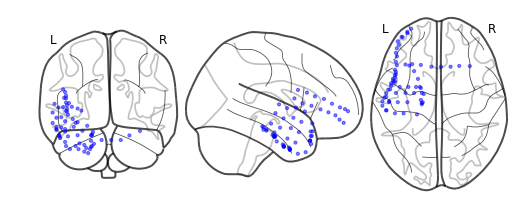

In [3]:
brain_data.plot_locs()

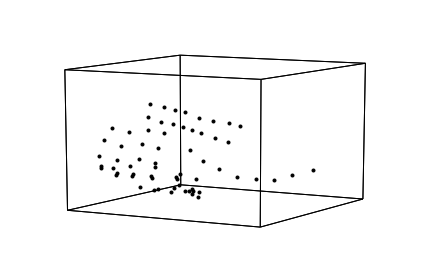

In [26]:
hyp.plot(brain_data.get_locs(), 'k.');

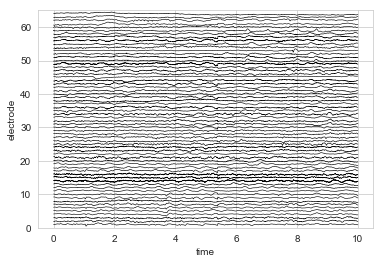

In [5]:
brain_data.plot_data()

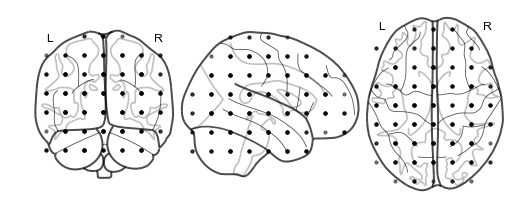

In [44]:
model_20mm = se.load('pyFR_k10r20_20mm')
model_20mm.plot_locs()

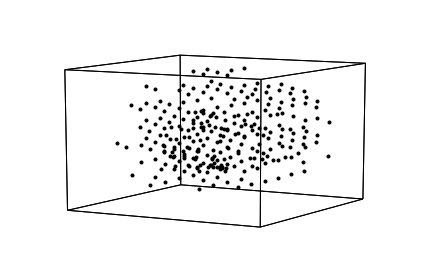

In [27]:
hyp.plot(model_20mm.get_locs(), 'k.');

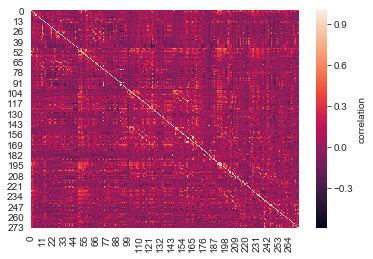

In [28]:
model_20mm.plot_data();

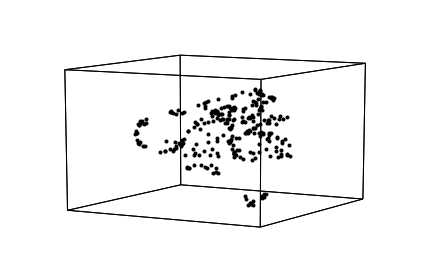

In [29]:
hyp.plot(model_20mm.get_model(), 'k.', reduce='UMAP');

In [30]:
brain_data_recon_20mm = model_20mm.predict(brain_data)

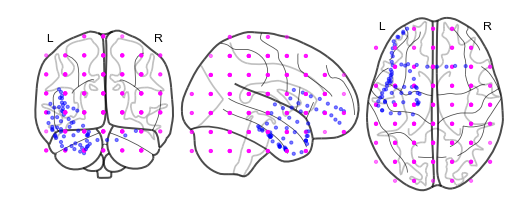

In [31]:
brain_data_recon_20mm.plot_locs()

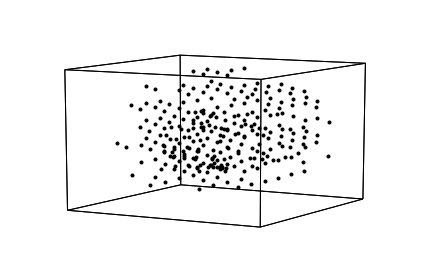

In [32]:
hyp.plot(brain_data_recon_20mm.get_locs(), 'k.');

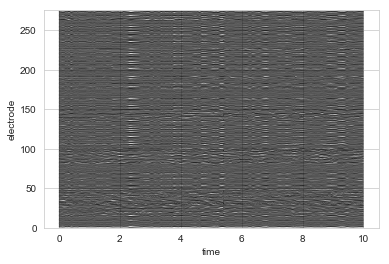

In [33]:
brain_data_recon_20mm.plot_data()

In [34]:
brain_data_recon_20mm.info()

Number of electrodes: 274
Recording time in seconds: [ 5.3984375 14.1328125]
Sample Rate in Hz: [256, 256]
Number of sessions: 2
Date created: Sun Jul 29 13:37:12 2018
Meta data: {}


In [36]:
nii_recon_20mm = brain_data_recon_20mm.to_nii(template='gray', vox_size=20)

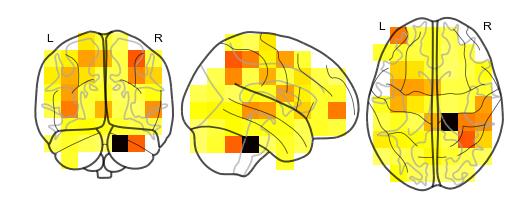

In [37]:
nii_recon_20mm.plot_glass_brain()

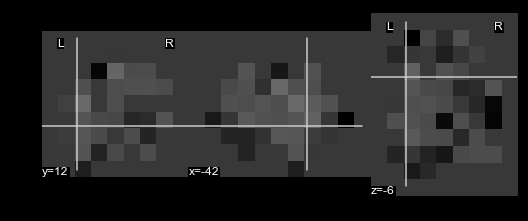

In [38]:
nii_recon_20mm.plot_anat()

In [39]:
gif_dir = os.path.join(os.getenv('HOME'), 'Desktop', 'recon_demo')
if not os.path.exists(gif_dir):
    os.makedirs(gif_dir)
nii_recon_20mm.make_gif(gif_dir, name='recon_20mm_gray', index=np.arange(50))
[os.remove(x) for x in glob(os.path.join(gif_dir, '*.png'))];